In [1]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import pylab as plt
from nltk.corpus import words
import pandas as pd
import sys
from scipy import spatial, stats
from collections import Counter, defaultdict
from matplotlib.colors import ListedColormap
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from numpy import dot
from numpy.linalg import norm
import operator
from statistics import mean, stdev
from scipy.stats import pearsonr 
import math
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import json
import networkx as nx
import copy
import pickle
import matplotlib.colors
from stargazer.stargazer import Stargazer, LineLocation
import time
#from linearmodels.panel import PanelOLS

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    #sys.stdout.write(str(d))
    sys.stdout.write('%d' % d)
    sys.stdout.flush()

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

C:\Users\ditong\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data

In [10]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

In [11]:
# JOB YEAR NPOSTS Medianpay Mineducation
jyn = defaultdict(lambda:defaultdict(lambda:0))
yjn = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
yje = defaultdict(lambda:defaultdict(lambda:0))
jyp = defaultdict(lambda:defaultdict(lambda:0))
yjp = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/year_socName_Nposts_aveMedianPay_aveMinEdu.txt',
          'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        year = int(line_lst[0])
        job = line_lst[1]
        num = int(line_lst[2])
        edu = line_lst[3]
        pay = line_lst[4]
        if year != 2019:
            jyn[job][year] = num
            yjn[year][job] = num
            if edu != 'nan' and edu != 'nan\n': 
                if float(edu) > 0:
                    jye[job][year] = float(edu)
                    yje[year][job.lower()] = float(edu)
            if pay != 'nan' and pay != 'nan\n':
                if float(pay) > 0:
                    jyp[job][year] = float(pay)
                    yjp[year][job] = float(pay)

In [17]:
# soc - pay - education
oe={}
op={}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/socName_aveMedianPay_aveMinEdu_socGroup.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        job = line_lst[0]
        op[job] = float(line_lst[1])
        oe[job] = float(line_lst[2])

In [18]:
# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf
                    
# job - top 5% defining skills
jys = defaultdict(lambda:defaultdict(lambda:[]))
syj = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    for job in yjas[year]:
        threshold = np.quantile(list(yjas[year][job].values()), [0.95])
        #threshold = np.mean(list(yjas[year][job].values()))
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                jys[job][year].append(skill)
                syj[skill][year].append(job)
        if len(jys[job][year]) < 5:
            #print(job, year)
            del jys[job][year]
            fulllist = syj[skill][year]
            syj[skill][year] = [value for value in fulllist if value != job]
            
# job - SKILL NUMBER
osn = {}
for job in jys:
    snlst = []
    for yr in jys[job]:
        if len(jys[job][yr]) != 0:
            snlst.append(len(jys[job][yr]))
    if snlst:
        osn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
osn = dict(sorted(osn.items(), key=operator.itemgetter(1),reverse=True))

### Extended Methods: Replication of Deming and Noray's (2020) Job Skill Change Measurement

In [57]:
# read in saved data
occ_y_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
occ_y_sfreq = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq_emp.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        occ = linelst[0]
        year = linelst[1]
        sfreqs = linelst[2:]
        for s in sfreqs:
            sk = s.split("_")[0]
            freq = int(s.split("_")[1])
            occ_y_skill_freq[occ][year][sk] = freq
            occ_y_sfreq[occ][year] += freq
            
occ_y_freq = defaultdict(lambda:defaultdict(lambda:0))            
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_npost_emp.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        occ = linelst[0]
        year = linelst[1]
        freq = int(linelst[2])
        occ_y_freq[occ][year] = freq

In [62]:
# calculate job skill change and save data
# weights
jw1 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if '2010' in occ_y_sfreq[j] and '2018' in occ_y_sfreq[j]:
            jw1[j] = (occ_y_sfreq[j]['2010'] / occ_y_sfreq[j]['2018']) / (occ_y_freq[j]['2010']/occ_y_freq[j]['2018'])
            if jw1[j] > 1:
                jw1[j] = 1
                
jw2 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if '2007' in occ_y_sfreq[j] and '2019' in occ_y_sfreq[j]:
            jw2[j] = (occ_y_sfreq[j]['2007'] / occ_y_sfreq[j]['2019']) / (occ_y_freq[j]['2007']/occ_y_freq[j]['2019'])
            if jw2[j] > 1:
                jw2[j] = 1
                
# skill probability
jyspro = copy.deepcopy(occ_y_skill_freq)
for j in jyspro:
    for y in jyspro[j]:
        for s in jyspro[j][y].keys():
            jyspro[j][y][s] = jyspro[j][y][s]/occ_y_freq[j][y]
            
# job change
jyc = defaultdict(lambda:defaultdict(lambda:0))
occsc79=defaultdict(lambda:0)
occsc80=defaultdict(lambda:0)
for j in jyspro:
    if '2007' in jyspro[j] and '2019' in jyspro[j]:
        # get the union of skills of 2 years
        alls = set(jyspro[j]['2007'].keys()).union(set(jyspro[j]['2019'].keys()))
        # skill probability change
        for s in alls:
            jyc[j]['07-19'] += abs(jyspro[j]['2019'][s] - jyspro[j]['2007'][s])
        jyc[j]['07-19'] = jyc[j]['07-19']*jw2[j]
        occsc79[j] = jyc[j]['07-19']
            
    if '2010' in jyspro[j] and '2018' in jyspro[j]:
        # get the union of skills of 2 years
        alls = set(jyspro[j]['2010'].keys()).union(set(jyspro[j]['2018'].keys()))
        # skill probability change
        for s in alls:
            jyc[j]['10-18'] += abs(jyspro[j]['2018'][s] - jyspro[j]['2010'][s])
        jyc[j]['10-18'] = jyc[j]['10-18']*jw1[j]
        occsc80[j] = jyc[j]['10-18']
        
# save 
df79 = pd.DataFrame()
sorted79 =  dict(sorted(occsc79.items(), key=operator.itemgetter(1), reverse=True))
df79['SOC'] = list(sorted79.keys())
df79["SkillChange"] = list(sorted79.values())
df79.to_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/0719Soc6SkillChange_emp.csv')

df80 = pd.DataFrame()
sorted80 =  dict(sorted(occsc80.items(), key=operator.itemgetter(1), reverse=True))
df80['SOC'] = list(sorted80.keys())
df80["SkillChange"] = list(sorted80.values())
df80.to_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/1018Soc6SkillChange_emp.csv')

In [3]:
# data in Deming and Noray (2020) appendix
OriData = pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/QJE_SOC6Change.xlsx')
SOCR = {}
for i, j in zip(OriData["occupation_title"], OriData["RATE"]):
    SOCR[str(i)] = j

# replication
ReplData = pd.read_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/0719Soc6SkillChange_emp.csv')
re = {}
for i, j in zip(ReplData['SOC'], ReplData["SkillChange"]):
    re[str(i)] = j

# calculate correlation
#re = occsc79    
repl = {}
for j in SOCR:
    if j in re:
        repl[j] = (SOCR[j],re[j])

x,y = zip(*list(repl.values()))
print(pearsonr(x,y))
# fig = plt.figure(figsize=(5,5))
# ax1 = fig.add_subplot(111)
# plt.scatter(x,y, label="r=0.87***")
# plt.title("Job Skill Change Replication, 2007-19", fontsize=16)
# plt.xlabel("Original Measure, 2007-19", fontsize=16)
# plt.ylabel("Replicated Measure, 2007-19", fontsize=16)
# plt.legend(fontsize=18)

(0.8696114554674294, 2.0059318581748458e-88)


### Extended Methods: Cluster Approach to Measure Occupational Skill Change

In [66]:
# skill--community
partition = defaultdict(lambda:[])
sp = {}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/partition_0.0_0.0_6_0.51.txt','r') as f:
    for line in f:
        skill = line.split('\t')[0]
        group = int(line.split('\t')[1])
        partition[group].append(skill)
        sp[skill] = group

# community labels
labels = ['business and managerial skills', 'engineering, technical, and manual skills', 
          'computer and programming skills', 'clerical and analytical skills', 
          'scientific and research skills', 'medical and health skills']

In [69]:
# job - skill community - frequency
jyscf = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for job in jys:
    for year in jys[job]:
        for s in jys[job][year]:
            if s in sp:
                jyscf[job][year][sp[s]] += 1
        #yjscf[year][job] = dict(sorted(yjscf[year][job].items(), key=operator.itemgetter(1), reverse=True))

# job - skill community - share change
occ_scc = defaultdict(lambda:0)
for occ in jyscf:
    if 2010 in jyscf[occ] and 2018 in jyscf[occ]:
        skills = set(jyscf[occ][2010].keys()).union(jyscf[occ][2018].keys())
        for skill in skills:   
            occ_scc[occ] += abs(jyscf[occ][2018][skill]/sum(jyscf[occ][2018].values()) - 
                          jyscf[occ][2010][skill]/sum(jyscf[occ][2010].values())) 
# sort the occupation by skill change
sorted_occscc = dict(sorted(occ_scc.items(), key=operator.itemgetter(1), reverse=True))

In [70]:
# skill cluster share change for two occupations
# computer programmers
# skill cluster freq for each year
fil_pc10 = defaultdict(lambda:0)
for k in jys["Computer Programmers"][2010]:
    if k in sp:
        fil_pc10[sp[k]] += 1
fil_pc18 = defaultdict(lambda:0)
for k in jys["Computer Programmers"][2018]:
    if k in sp:
        fil_pc18[sp[k]] += 1
allcc = set(fil_pc10.keys()).union(fil_pc18.keys())
# skill cluster share change
sdiffCC = {}
for k in allcc:
    sdiffCC[k] = abs(fil_pc18[k]/sum(fil_pc18.values()) - fil_pc10[k]/sum(fil_pc10.values()))

# Food Batchmakers
fil_pb10 = defaultdict(lambda:0)
for k in jys['Food Batchmakers'][2010]:
    if k in sp:
        fil_pb10[sp[k]] += 1
fil_pb18 = defaultdict(lambda:0)
for k in jys['Food Batchmakers'][2018]:
    if k in sp:
        fil_pb18[sp[k]] += 1
allbc = set(fil_pb10.keys()).union(fil_pb18.keys())

sdiffBC = {}
for k in allbc:
    sdiffBC[k] = abs(fil_pb18[k]/sum(fil_pb18.values()) - fil_pb10[k]/sum(fil_pb10.values()))

In [73]:
# 200 dimension Job-Year-Vector
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

# job change from 2010 to 2018: 1 - dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

In [71]:
occ_scc['Computer Programmers'], occ_scc["Food Batchmakers"]

(0.19677965685672907, 0.3553921568627451)

(0.7618382894447562, 7.380695063066697e-139)


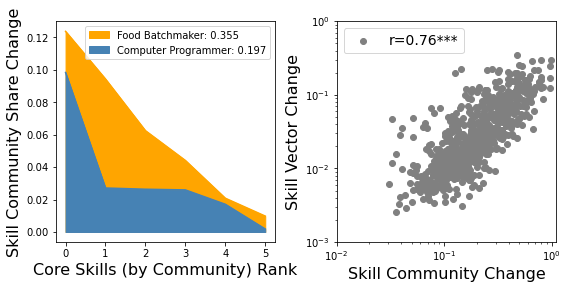

In [74]:
fig = plt.figure(figsize=(8,4))
ax2 = fig.add_subplot(121)
sb = sorted(sdiffBC.values(), reverse=True)
plt.plot(sb, color="orange")
plt.fill_between(range(len(sb)),sb,0,color="orange", label="Food Batchmaker: 0.355")
sc=sorted(sdiffCC.values(), reverse=True)
plt.plot(sc, color="steelblue")
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="Computer Programmer: 0.197")
plt.legend(fontsize=10)
plt.ylabel("Skill Community Share Change", fontsize=16)
plt.xlabel("Core Skills (by Community) Rank", fontsize=16)        


ax2 = fig.add_subplot(122)
scc_vec = {}
for j in sorted_occscc:
    if j in jtr:
        scc_vec[j] = (sorted_occscc[j],jtr[j])
x,y = zip(*list(scc_vec.values()))
print(pearsonr(np.log(x),np.log(y)))
plt.scatter(x,y, label="r=0.76***", color="grey")

# x=np.array(x).reshape(-1, 1)
# y=np.array(y).reshape(-1, 1)
# poly = PolynomialFeatures(degree = 1) 
# X_poly = poly.fit_transform(x) 
# poly.fit(X_poly, y) 
# lin2 = LinearRegression() 
# lin2.fit(X_poly, y) 
# xnew = np.linspace(0,3,100).reshape(-1, 1)
# plt.plot(xnew, lin2.predict(poly.fit_transform(xnew)), color = '#a9cbd2', linewidth=5)

plt.xlabel("Skill Community Change", fontsize=16)
plt.ylabel("Skill Vector Change", fontsize=16)
plt.legend(loc=2, fontsize=14)

plt.ylim(1/1000,1)
plt.xlim(1/100,1.1)
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/SI/SI_ClusterVector.pdf') 

### Extended Data: Representativeness of Job Ads Data Collected by Burning Glass Technologies

In [7]:
# BLS Education
df_2018e=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/education.xlsx', 
                      sheet_name="Assignment", header=1)

eduy = []
for i in df_2018e['Typical education needed for entry']:
    if pd.isnull(i) == True:
        eduy.append('nan')
    elif i == 'No formal educational credential':
        eduy.append(0)
    elif i =='High school diploma or equivalent':
        eduy.append(12)  
    elif i in ['High school diploma or equivalent','Some college, no degree','Postsecondary nondegree award']:
        eduy.append(12)
#     elif i in ['Some college, no degree','Postsecondary nondegree award']:
#         eduy.append(13)
#     elif i in ["Associate's degree",'Some college, no degree','Postsecondary nondegree award']:
#         eduy.append(14)
    elif i == "Associate's degree":
        eduy.append(14)
    elif i == "Bachelor's degree":
        eduy.append(16)
    elif i == "Master's degree":
        eduy.append(18)
    elif i == "Doctoral or professional degree":
        eduy.append(21)
df_2018e['eduy']=eduy

In [10]:
# bls pay and employment
df_2018=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/national_M2018_dl.xlsx')
df_2010=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/national_M2010_dl.xls')

bls_on18 = {}
bls_op18 = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['TOT_EMP'], df_2018['A_MEDIAN']):
    if i in yjn[2018] and j != '*'and j !='#':
        bls_on18[i] = j
    if i in yjp[2018] and k != '*' and k !='#':
        bls_op18[i] = k
        
bls_on10 = {}
bls_op10 = {}
for i, j, k in zip(df_2010['OCC_TITLE'], df_2010['TOT_EMP'], df_2010['A_MEDIAN']):
    if i in yjn[2010]and j != '*' and j !='#':
        bls_on10[i] = j
    if i in yjp[2010] and k != '*' and k!= '#':
        bls_op10[i] = k

(0.803481793733344, 9.100595501674793e-179)
(0.7573028144504227, 1.472688577128253e-145)
(0.8665497008620799, 1.314713665703486e-234)
(0.8291506407884586, 6.969904131567013e-194)
682
(0.9155349192602655, 3.7376760681076806e-271)


<ipython-input-53-cb5cdec8fd12>:51: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2)
<ipython-input-53-cb5cdec8fd12>:52: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', basey=2)


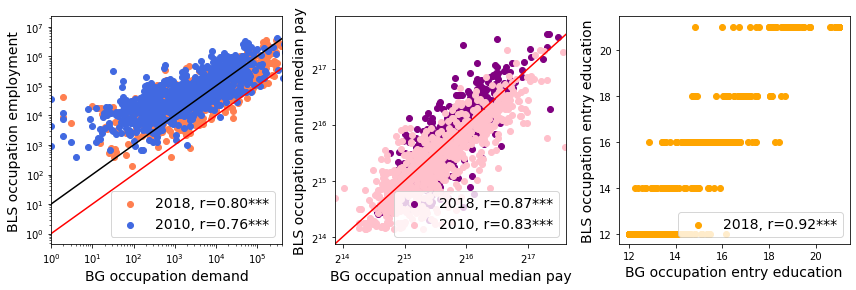

In [53]:
fig = plt.figure(figsize=(12,4))
ax0 = fig.add_subplot(131)
bls_bgon = {}
for j in bls_on18:
    bls_bgon[j] = (yjn[2018][j], bls_on18[j])
x,y = zip(*list(bls_bgon.values()))
plt.scatter(x,y,color="coral", label='2018, r=0.80'+ '***')
corr1=pearsonr(np.log(x),np.log(y))
print(corr1)

bls_bgon = {}
for j in bls_on10:
    bls_bgon[j] = (yjn[2010][j], bls_on10[j])
x,y = zip(*list(bls_bgon.values()))
plt.scatter(x,y,color="royalblue", label='2010, r=0.76'+ '***')
corr2=pearsonr(np.log(x),np.log(y))
print(corr2)

#plt.ylim(1,4000000)
plt.xlim(1,400000)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('BLS occupation employment', fontsize=14)
plt.xlabel('BG occupation demand',fontsize=14)
plt.plot([1,10**6], [1,10**6], 'r-')
plt.plot([1,10**6], [10,10**7], 'k-')
plt.legend(fontsize=14, loc=4)

ax0 = fig.add_subplot(132)
bls_bgop = {}
for j in bls_op18:
    bls_bgop[j] = (yjp[2018][j], float(bls_op18[j]))
x,y = zip(*list(bls_bgop.values()))
plt.scatter(x,y,color="purple", label='2018, r=0.87'+ '***')
corr1=pearsonr(np.log(x), np.log(y))
print(corr1)

bls_bgop = {}
for j in bls_op10:
    bls_bgop[j] = (yjp[2010][j], float(bls_op10[j]))
x1,y1 = zip(*list(bls_bgop.values()))
plt.scatter(x1,y1,color="pink", label='2010, r=0.83'+ '***')
corr2=pearsonr(np.log(x1), np.log(y1))
print(corr2)

plt.ylabel('BLS occupation annual median pay',fontsize=14)
plt.xlabel('BG occupation annual median pay',fontsize=14)
plt.xlim(15000, 200000)
plt.ylim(15000, 250000)
plt.plot([1,10**6], [1,10**6], 'r-')
plt.xscale('log', basex=2)
plt.yscale('log', basey=2)
plt.legend(fontsize=14, loc=4)


ax0 = fig.add_subplot(133)
bls_bgoe = {}
for i, j in zip(df_2018e['2018 National Employment Matrix title and code'], 
               df_2018e['eduy']):
    if i.lower() in yje[2018] and j != 'nan' and j > 0: #and j != 13:
        bls_bgoe[i.lower()] = (yje[2018][i.lower()], j)
print(len(bls_bgoe))
x,y = zip(*list(bls_bgoe.values()))
plt.scatter(x,y,color="orange", label='2018, r=0.92'+ '***')
plt.ylabel('BLS occupation entry education',fontsize=14)
plt.xlabel('BG occupation entry education',fontsize=14)
plt.legend(fontsize=14, loc=4)
corr=pearsonr(x, y)
print(corr)
plt.tight_layout()

#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/SI/BGValidation.pdf') 

## Robustness Checks

### 1. Regression: control for employer concentration

In [5]:
# job-core skill
def YearJobSkillFreq(filename):
    dictyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
    with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/'+filename, 'r') as f:
        for line in f:
            line_lst = line.split("\t")
            job = line_lst[0]
            year = int(line_lst[1])
            skills = line_lst[2:]
            if year != 2019:
                if len(skills) > 5:
                    for skill_tfidf in skills:
                        skill = skill_tfidf.split('_')[0].lower()
                        tfidf = float(skill_tfidf.split('_')[1])
                        dictyjas[year][job][skill] = tfidf
                        
    return dictyjas

def JobYearDefSkill(dictyjas, quant):
    dictjys = defaultdict(lambda:defaultdict(lambda:[]))
    for year in dictyjas:
        for job in dictyjas[year]:
            threshold = np.quantile(list(dictyjas[year][job].values()), [quant])
            for skill in dictyjas[year][job]:
                if dictyjas[year][job][skill] > threshold:
                    dictjys[job][year].append(skill)
            if len(dictjys[job][year]) < 5:
                del dictjys[job][year]

    return dictjys

lcllocyjas = YearJobSkillFreq('lclloc_occ_year_skill_freq.txt')
lcllocjys = JobYearDefSkill(lcllocyjas, 0.95)

lcslocyjas = YearJobSkillFreq('lcsloc_occ_year_skill_freq.txt')
lcslocjys = JobYearDefSkill(lcslocyjas, 0.95)

scllocyjas = YearJobSkillFreq('sclloc_occ_year_skill_freq.txt')
scllocjys = JobYearDefSkill(scllocyjas, 0.95)

scslocyjas = YearJobSkillFreq('scsloc_occ_year_skill_freq.txt')
scslocjys = JobYearDefSkill(scslocyjas, 0.95)

In [6]:
len(lcllocjys), len(lcslocjys), len(scllocjys), len(scslocjys)

(830, 817, 816, 750)

In [7]:
# key independent variable: skill number
def JobNSkill(dictjys):
    dictosn = {}
    for job in dictjys:
        snlst = []
        for yr in dictjys[job]:
            if len(dictjys[job][yr]) != 0:
                snlst.append(len(dictjys[job][yr]))
        if snlst:
            dictosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
    dictosn = dict(sorted(dictosn.items(), key=operator.itemgetter(1),reverse=True))
    
    return dictosn

lcllocosn = JobNSkill(lcllocjys)
lcslocosn = JobNSkill(lcslocjys)
scllocosn = JobNSkill(scllocjys)
scslocosn = JobNSkill(scslocjys)

In [12]:
# key depedent variable: job skill change

def JobChange(dictjys):
    
    dictjyv=defaultdict(lambda:defaultdict(lambda:''))
    for j in dictjys:
        for y in dictjys[j]:
            dictjyv[j][y] = np.mean([model.wv[s] for s in dictjys[j][y] if s in model.wv], axis=0) 
    
    dictjtr = {}
    for j in dictjyv:
        if 2010 in dictjyv[j] and 2018 in dictjyv[j]:
            if j in jyn:
                if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                    jtrrr = np.dot(dictjyv[j][2018], dictjyv[j][2010]
                                  )/(np.linalg.norm(dictjyv[j][2018])* np.linalg.norm(dictjyv[j][2010]))
                    if type(jtrrr) == np.float32:
                        dictjtr[j] = 1 - jtrrr

    dictjtr = dict(sorted(dictjtr.items(), key=operator.itemgetter(1)))
    
    return dictjtr

lcllocjtr = JobChange(lcllocjys)
lcslocjtr = JobChange(lcslocjys)
scllocjtr = JobChange(scllocjys)
scslocjtr = JobChange(scslocjys)

In [13]:
# occupations that appear in all 4 datasets
commonj=list(set(lcllocjtr.keys()).intersection(set(lcslocjtr)).intersection(set(scllocjtr)).intersection(set(scslocjtr)))

In [15]:
# key control: employer concentration
Lloc_OCCYEC=defaultdict(lambda:[])
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/LLOCyear_occ_empcon.txt', 'r') as f1:
    for line in f1:
        line_lst = line.split('\t')
        yr = int(line_lst[0])
        occ = line_lst[1]
        ec = float(line_lst[2])
        if not np.isnan(ec):
            Lloc_OCCYEC[occ].append(ec)
            
Lloc_OCCEC=defaultdict(lambda:0)
for occ in Lloc_OCCYEC:
    Lloc_OCCEC[occ] = np.mean(Lloc_OCCYEC[occ])

Sloc_OCCYEC=defaultdict(lambda:[])
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/SLOCyear_occ_empcon.txt', 'r') as f1:
    for line in f1:
        line_lst = line.split('\t')
        yr = int(line_lst[0])
        occ = line_lst[1]
        ec = float(line_lst[2])
        if not np.isnan(ec):
            Sloc_OCCYEC[occ].append(ec)
            
Sloc_OCCEC=defaultdict(lambda:0)
for occ in Sloc_OCCYEC:
    Sloc_OCCEC[occ] = np.mean(Sloc_OCCYEC[occ])

In [19]:
# put variables in a dataframe
reg_df=pd.DataFrame(columns = ['Occupation', 'SkillChange', 'LogSkillN', 'LogSkillNAll', 'Education', 'LogPay', 'LargeEmployer',
                'LargeMarket','EmployerConcentration', 'LargeEmployer_LogSkillN', 'LargeMarket_LogSkillN',
                               'LargeEmployer_LogSkillNAll', 'LargeMarket_LogSkillNAll',
                    'LargeEmployer_LogPay', 'LargeMarket_LogPay', 'LargeEmployer_Education', 'LargeMarket_Education'])

for j in lcllocjtr:
    if j in lcllocosn and j in oe and j in op and j in Lloc_OCCEC: #and j in commonj:
        reg_df=reg_df.append({'Occupation': j, 'SkillChange': lcllocjtr[j], 'LogSkillN': np.log(lcllocosn[j]), 
    'LogSkillNAll': np.log(osn[j]), 'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 1, 'LargeMarket': 1,
    'EmployerConcentration': Lloc_OCCEC[j]**2, 'LargeEmployer_LogSkillN': 1*np.log(lcllocosn[j]), 
    'LargeMarket_LogSkillN': 1*np.log(lcllocosn[j]),'LargeEmployer_LogSkillNAll': 1*np.log(osn[j]), 
    'LargeMarket_LogSkillNAll': 1*np.log(osn[j]),'LargeEmployer_LogPay':1*np.log(op[j]), 'LargeMarket_LogPay': 1*np.log(op[j]), 
                'LargeEmployer_Education': 1*oe[j], 'LargeMarket_Education': 1*oe[j]}, ignore_index = True)

for j in  lcslocjtr:
    if j in lcslocosn and j in oe and j in op and j in Sloc_OCCEC: # and j in commonj:
        reg_df=reg_df.append({'Occupation': j,'SkillChange':  lcslocjtr[j], 'LogSkillN': np.log(lcslocosn[j]), 
                              'LogSkillNAll': np.log(osn[j]),
    'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 1, 'LargeMarket': 0,'EmployerConcentration': Sloc_OCCEC[j]**2, 
                'LargeEmployer_LogSkillN': 1*np.log(lcslocosn[j]), 'LargeMarket_LogSkillN': 0*np.log(lcslocosn[j]),
                'LargeEmployer_LogSkillNAll': 1*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 0*np.log(osn[j]),
                'LargeEmployer_LogPay':1*np.log(op[j]), 'LargeMarket_LogPay': 0*np.log(op[j]), 
                'LargeEmployer_Education': 1*oe[j], 'LargeMarket_Education': 0*oe[j]}, ignore_index = True)
        
for j in scllocjtr:
    if j in scllocosn and j in oe and j in op and j in Lloc_OCCEC: # and j in commonj:
        reg_df=reg_df.append({'Occupation': j, 'SkillChange':scllocjtr[j], 'LogSkillN': np.log(scllocosn[j]), 
                              'LogSkillNAll': np.log(osn[j]), 
    'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 0, 'LargeMarket': 1,'EmployerConcentration': Lloc_OCCEC[j]**2, 
                'LargeEmployer_LogSkillN': 0*np.log(scllocosn[j]), 'LargeMarket_LogSkillN': 1*np.log(scllocosn[j]),
                'LargeEmployer_LogSkillNAll': 0*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 1*np.log(osn[j]),
                'LargeEmployer_LogPay':0*np.log(op[j]), 'LargeMarket_LogPay': 1*np.log(op[j]), 
                'LargeEmployer_Education': 0*oe[j], 'LargeMarket_Education': 1*oe[j]}, ignore_index = True)
        
for j in scslocjtr:
    if j in scslocosn and j in oe and j in op and j in Sloc_OCCEC: # and j in commonj:
        reg_df=reg_df.append({'Occupation': j, 'SkillChange': scslocjtr[j], 'LogSkillN': np.log(scslocosn[j]), 
                              'LogSkillNAll': np.log(osn[j]),
    'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 0, 'LargeMarket': 0,'EmployerConcentration': Sloc_OCCEC[j]**2, 
                'LargeEmployer_LogSkillN': 0*np.log(scslocosn[j]), 'LargeMarket_LogSkillN': 0*np.log(scslocosn[j]),
                'LargeEmployer_LogSkillNAll': 0*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 0*np.log(osn[j]),
                'LargeEmployer_LogPay':0*np.log(op[j]), 'LargeMarket_LogPay': 0*np.log(op[j]), 
                'LargeEmployer_Education': 0*oe[j], 'LargeMarket_Education': 0*oe[j]}, ignore_index = True)
#reg_df = reg_df.set_index(['Occupation'])

(array([ 52.,  74., 120., 151., 187., 217., 239., 242., 339., 203.]),
 array([0.00869879, 0.10580225, 0.20290571, 0.30000916, 0.39711262,
        0.49421608, 0.59131954, 0.68842299, 0.78552645, 0.88262991,
        0.97973337]),
 <BarContainer object of 10 artists>)

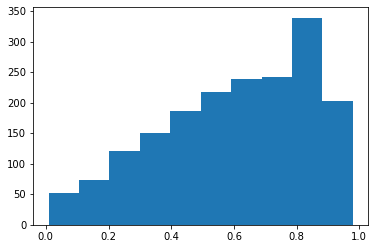

In [20]:
plt.hist(reg_df['EmployerConcentration'])

In [21]:
mod1 = smf.ols('SkillChange ~ LogSkillNAll', data=reg_df)
res1 = mod1.fit()

mod2= smf.ols('SkillChange ~ Education', data=reg_df)
res2 = mod2.fit()

mod3= smf.ols('SkillChange ~ LogPay', data=reg_df)
res3 = mod3.fit()

mod5= smf.ols('SkillChange ~ LogSkillNAll + EmployerConcentration', data=reg_df)
res5 = mod5.fit()

mod6= smf.ols('SkillChange ~ Education + EmployerConcentration', data=reg_df)
res6 = mod6.fit()

mod7= smf.ols('SkillChange ~ LogPay + EmployerConcentration', data=reg_df)
res7 = mod7.fit()

stargazer = Stargazer([res1, res3, res2, res5, res7, res6])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity')
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'], [1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillNAll', 'LogPay', 'Education', 'EmployerConcentration'])

stargazer.rename_covariates({'LogSkillNAll': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
    'Education': 'Education', 'EmployerConcentration': 'Sq. Emp. Concentr.'})
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer

In [22]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Explaining Job Skill Change Variation with Skill Complexity}
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent variable:}} \
\cr \cline{6-7}
\\[-1.8ex] & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2} & \multicolumn{1}{c}{Model 3} & \multicolumn{1}{c}{Model 4} & \multicolumn{1}{c}{Model 5} & \multicolumn{1}{c}{Model 6}  \\
\hline \\[-1.8ex]
 Skill Complexity & -0.043$^{***}$ & & & -0.034$^{***}$ & & \\
  & (0.002) & & & (0.002) & & \\
 Log Annual Pay & & -0.025$^{***}$ & & & -0.023$^{***}$ & \\
  & & (0.004) & & & (0.003) & \\
 Education & & & -0.004$^{***}$ & & & -0.004$^{***}$ \\
  & & & (0.001) & & & (0.001) \\
 Sq. Emp. Concentr. & & & & 0.070$^{***}$ & 0.109$^{***}$ & 0.111$^{***}$ \\
  & & & & (0.005) & (0.006) & (0.006) \\
\hline \\[-1.8ex]
 Observations & 1,824 & 1,824 & 1,824 & 1,824 & 1,824 & 1,824 \\
 $R^2$ & 0.263 & 0.023 & 0.019 & 0.324 & 0.196 & 0.197

In [23]:
resf1 =  smf.ols("SkillChange ~ LargeEmployer + C(Occupation)", data=reg_df).fit()
resf2 =  smf.ols("SkillChange ~ LargeMarket + C(Occupation)", data=reg_df).fit()
resf3 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + C(Occupation)+ EmployerConcentration", data=reg_df).fit()
resf4 =  smf.ols("SkillChange ~ LargeEmployer + LargeEmployer_LogSkillNAll + C(Occupation)", data=reg_df).fit()
resf5 =  smf.ols("SkillChange ~ LargeMarket + LargeMarket_LogSkillNAll + C(Occupation)", data=reg_df).fit()
resf6 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + LargeEmployer_LogSkillNAll + LargeMarket_LogSkillNAll + C(Occupation)+ EmployerConcentration", 
                 data=reg_df).fit()

stargazerf = Stargazer([resf1, resf2, resf3, resf4, resf5, resf6])

stargazerf.title('Explaining Job Skill Change Variation with Employer and Market size')
stargazerf.custom_columns(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'], [1, 1, 1, 1, 1, 1])
stargazerf.show_model_numbers(False)
stargazerf.covariate_order(['LargeEmployer[T.1]', 'LargeMarket[T.1]', 'LargeEmployer_LogSkillNAll', 'LargeMarket_LogSkillNAll',
                            'EmployerConcentration'])
stargazerf.rename_covariates({'LargeEmployer[T.1]': 'Large Employer', 'LargeMarket[T.1]': 'Large Market', 
    'LargeEmployer_LogSkillNAll': 'LE * SC', 'LargeMarket_LogSkillNAll': 'LM * SC', 'EmployerConcentration': 'Sq. Emp. Concentr.'})
stargazerf.significance_levels([0.05, 0.01, 0.001])
stargazerf.add_line('Occ. FE', ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'])
stargazerf.add_custom_notes(['LE refers to Large Employer dummy. LM refers to Large Market dummy. SC refers to Skill Complexity of job, which is measured by the log number of top 5\% core skills. Sq. Emp. Concentr. refers to squared employer concentration.'])
stargazerf

In [24]:
print(stargazerf.render_latex())

\begin{table}[!htbp] \centering
  \caption{Explaining Job Skill Change Variation with Employer and Market size}
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent variable:}} \
\cr \cline{6-7}
\\[-1.8ex] & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2} & \multicolumn{1}{c}{Model 3} & \multicolumn{1}{c}{Model 4} & \multicolumn{1}{c}{Model 5} & \multicolumn{1}{c}{Model 6}  \\
\hline \\[-1.8ex]
 Large Employer & -0.018$^{***}$ & & -0.024$^{***}$ & -0.066$^{***}$ & & -0.117$^{***}$ \\
  & (0.002) & & (0.002) & (0.017) & & (0.015) \\
 Large Market & & -0.036$^{***}$ & -0.077$^{***}$ & & -0.109$^{***}$ & -0.144$^{***}$ \\
  & & (0.002) & (0.008) & & (0.015) & (0.015) \\
 LE * SC & & & & 0.011$^{**}$ & & 0.020$^{***}$ \\
  & & & & (0.004) & & (0.003) \\
 LM * SC & & & & & 0.016$^{***}$ & 0.023$^{***}$ \\
  & & & & & (0.003) & (0.005) \\
 Sq. Emp. Concentr. & & & -0.086$^{***}$ & & & 0.004$^{}$ \\
  & & & (0.019) & 

In [ ]:
# correlation and coefficients for main analyses

# main analysis coefficients for three measurements

# # skill number and our transformation pressures
# sn_tr = {}
# for j in osn:
#     if j in jtr:
#         sn_tr[j] = (osn[j], jtr[j])
# x,y = zip(*list(sn_tr.values()))
# print("skill # and transformation", pearsonr(x,y))
# X = sm.add_constant(x)
# results = sm.OLS(y,X).fit()
# print(results.summary())
# print("\n")

# # skill number and Deming's original measurement
# sn_trD = {}
# for j in osn:
#     if j in SOCR:
#         sn_trD[j] = (osn[j], SOCR[j])
# x,y = zip(*list(sn_trD.values()))
# print("skill # and Deming's original measurement", pearsonr(x,y))
# X = sm.add_constant(x)
# results = sm.OLS(y,X).fit()
# print(results.summary())
# print("\n")

# # skill number and replicated Deming's measurement 19-07
# sn_tr97 = {}
# for j in osn:
#     if j in occsc97:
#         sn_tr97[j] = (osn[j], occsc97[j])
# x,y = zip(*list(sn_tr97.values()))
# print("skill # and Replicated 19-07 measurment", pearsonr(x,y))
# X = sm.add_constant(x)
# results = sm.OLS(y,X).fit()
# print(results.summary())
# print("\n")

# # skill number and replicated Deming's measurement 18-10
# sn_tr80 = {}
# for j in osn:
#     if j in occsc80:
#         sn_tr80[j] = (osn[j], occsc80[j])
# x,y = zip(*list(sn_tr80.values()))
# print("skill # and Replicated 18-10 measurment", pearsonr(x,y))
# X = sm.add_constant(x)
# results = sm.OLS(y,X).fit()
# print(results.summary())
# print("\n")

# education and job transformation
# e_tr = {}
# for j in jtr:
#     if j in oe:
#         e_tr[j] = (oe[j], jtr[j])
# x,y = zip(*list(e_tr.values()))
# print("education and transformation",pearsonr(x,y))
# x = sm.add_constant(x)
# results = sm.OLS(y,x).fit()
# print(results.summary())  
# print("\n")

# # pay and job transformation
# p_tr = {}
# for j in jtr:
#     if j in op:
#         p_tr[j] = (jtr[j], np.log(op[j]))
# m,n = zip(*list(p_tr.values()))
# print("transformation and pay", pearsonr(m,n))
# m = sm.add_constant(m)
# results = sm.OLS(n,m).fit()
# print(results.summary()) 
# print("\n")

### 2. Regression: different job content scope with skill weights

In [25]:
# weights for each skill for each job
jysw=defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for yr in yjas:
    for j in yjas[yr]:
        freqsum=np.sum(list(yjas[yr][j].values()))
        for s in yjas[yr][j]:
            jysw[j][yr][s] = yjas[yr][j][s] / freqsum        

In [26]:
# 200 dimension Job-Year-Vector
jyv_w = defaultdict(lambda:defaultdict(lambda:''))
for j in jysw:
    for y in jysw[j]:
        jyv_w[j][y] = np.sum([model.wv[s]*jysw[j][y][s] for s in jysw[j][y].keys() if s in model.wv],axis=0)

# job change from 2010 to 2018: 1 - dot product between 2 job vectors
jtr_w = {}
for j in jyv_w:
    if 2010 in jyv_w[j] and 2018 in jyv_w[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr_w[j] = 1- np.dot(jyv_w[j][2018], jyv_w[j][2010])/(
                    np.linalg.norm(jyv_w[j][2018])* np.linalg.norm(jyv_w[j][2010]))

jtr_w = dict(sorted(jtr_w.items(), key=operator.itemgetter(1)))

In [27]:
def weighted_change_coreskill(dictyjas, quant):
    
    # filter the defining skills
    jys2 = defaultdict(lambda:defaultdict(lambda:[]))
    yjas2 = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
    for year in dictyjas:
        for job in dictyjas[year]:
            threshold = np.quantile(list(dictyjas[year][job].values()), [quant])
            for skill in yjas[year][job]:
                if dictyjas[year][job][skill] >= threshold:
                    jys2[job][year].append(skill)
                    yjas2[year][job][skill]+= dictyjas[year][job][skill]
            if len(jys2[job][year]) < 5:
                #print(job, year)
                del jys2[job][year]

    jycsw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
    for yr in yjas2:
        for j in yjas2[yr]:
            freqsum=np.sum(list(yjas2[yr][j].values()))
            for s in yjas2[yr][j]:
                jycsw[j][yr][s] = yjas2[yr][j][s] / freqsum   
                
    # 200 dimension Job-Year-Vector
    jyv_w2 = defaultdict(lambda:defaultdict(lambda:''))
    for j in jycsw:
        for y in jycsw[j]:
            jyv_w2[j][y] = np.sum([model.wv[s]*jycsw[j][y][s] for s in jycsw[j][y].keys() if s in model.wv],axis=0)

    # job change from 2010 to 2018: 1 - dot product between 2 job vectors
    jtr_w2 = {}
    for j in jyv_w2:
        if 2010 in jyv_w2[j] and 2018 in jyv_w2[j]:
            if j in jyn:
                # retain jobs with more than 100 posts in both 2010 and 2018
                if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                    jtr_w2[j] = 1- np.dot(jyv_w2[j][2018], jyv_w2[j][2010])/(
                        np.linalg.norm(jyv_w2[j][2018])* np.linalg.norm(jyv_w2[j][2010]))

    jtr_w2 = dict(sorted(jtr_w2.items(), key=operator.itemgetter(1)))
    
    return jtr_w2

In [28]:
def reg_dataframe(lcllocjtrwa, lcslocjtrwa, scllocjtrwa, scslocjtrwa):
    # put variables in a dataframe
    reg_df2=pd.DataFrame(columns = ['Occupation','SkillChange', 'LogSkillN', 'LogSkillNAll', 'Education', 'LogPay', 'LargeEmployer', 'LargeMarket',
                                  'EmployerConcentration', 'LargeEmployer_LogSkillN', 'LargeMarket_LogSkillN',
                                   'LargeEmployer_LogSkillNAll', 'LargeMarket_LogSkillNAll',
                        'LargeEmployer_LogPay', 'LargeMarket_LogPay', 'LargeEmployer_Education', 'LargeMarket_Education'])

    for j in lcllocjtrwa:
        if j in lcllocosn and j in oe and j in op and j in Lloc_OCCEC:
            reg_df2=reg_df2.append({'Occupation': j, 'SkillChange': lcllocjtrwa[j], 'LogSkillN': np.log(lcllocosn[j]),
                'LogSkillNAll': np.log(osn[j]),'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 1, 
                                    'LargeMarket': 1,'EmployerConcentration': Lloc_OCCEC[j]**2, 
                    'LargeEmployer_LogSkillN': 1*np.log(lcllocosn[j]), 'LargeMarket_LogSkillN': 1*np.log(lcllocosn[j]),
                    'LargeEmployer_LogSkillNAll': 1*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 1*np.log(osn[j]),
                    'LargeEmployer_LogPay':1*np.log(op[j]), 'LargeMarket_LogPay': 1*np.log(op[j]), 
                    'LargeEmployer_Education': 1*oe[j], 'LargeMarket_Education': 1*oe[j]}, ignore_index = True)

    for j in  lcslocjtrwa:
        if j in lcslocosn and j in oe and j in op and j in Sloc_OCCEC:
            reg_df2=reg_df2.append({'Occupation': j, 'SkillChange':  lcslocjtrwa[j], 'LogSkillN': np.log(lcslocosn[j]), 
                                    'LogSkillNAll': np.log(osn[j]), 'Education': oe[j], 'LogPay': np.log(op[j]), 
                                    'LargeEmployer': 1, 'LargeMarket': 0,'EmployerConcentration': Sloc_OCCEC[j]**2, 
                    'LargeEmployer_LogSkillN': 1*np.log(lcslocosn[j]), 'LargeMarket_LogSkillN': 0*np.log(lcslocosn[j]),
                    'LargeEmployer_LogSkillNAll': 1*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 0*np.log(osn[j]),
                    'LargeEmployer_LogPay':1*np.log(op[j]), 'LargeMarket_LogPay': 0*np.log(op[j]), 
                    'LargeEmployer_Education': 1*oe[j], 'LargeMarket_Education': 0*oe[j]}, ignore_index = True)

    for j in scllocjtrwa:
        if j in scllocosn and j in oe and j in op and j in Lloc_OCCEC:
            reg_df2=reg_df2.append({'Occupation': j, 'SkillChange':scllocjtrwa[j], 'LogSkillN': np.log(scllocosn[j]), 
                                    'LogSkillNAll': np.log(osn[j]),  'Education': oe[j], 'LogPay': np.log(op[j]), 
                                    'LargeEmployer': 0, 'LargeMarket': 1,'EmployerConcentration': Lloc_OCCEC[j]**2, 
                    'LargeEmployer_LogSkillN': 0*np.log(scllocosn[j]), 'LargeMarket_LogSkillN': 1*np.log(scllocosn[j]),
                    'LargeEmployer_LogSkillNAll': 0*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 1*np.log(osn[j]),
                    'LargeEmployer_LogPay':0*np.log(op[j]), 'LargeMarket_LogPay': 1*np.log(op[j]), 
                    'LargeEmployer_Education': 0*oe[j], 'LargeMarket_Education': 1*oe[j]}, ignore_index = True)

    for j in scslocjtrwa:
        if j in scslocosn and j in oe and j in op and j in Sloc_OCCEC:
            reg_df2=reg_df2.append({'Occupation': j, 'SkillChange': scslocjtrwa[j], 'LogSkillN': np.log(scslocosn[j]), 
                                    'LogSkillNAll': np.log(osn[j]), 'Education': oe[j], 'LogPay': np.log(op[j]),
                                    'LargeEmployer': 0, 'LargeMarket': 0,'EmployerConcentration': Sloc_OCCEC[j]**2, 
                    'LargeEmployer_LogSkillN': 0*np.log(scslocosn[j]), 'LargeMarket_LogSkillN': 0*np.log(scslocosn[j]),
                    'LargeEmployer_LogSkillNAll': 0*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 0*np.log(osn[j]),
                    'LargeEmployer_LogPay':0*np.log(op[j]), 'LargeMarket_LogPay': 0*np.log(op[j]), 
                    'LargeEmployer_Education': 0*oe[j], 'LargeMarket_Education': 0*oe[j]}, ignore_index = True)
            
    return reg_df2

In [29]:
lcllocjtrwa = weighted_change_coreskill(lcllocyjas, 0)
lcslocjtrwa = weighted_change_coreskill(lcslocyjas, 0)
scllocjtrwa = weighted_change_coreskill(scllocyjas, 0)
scslocjtrwa = weighted_change_coreskill(scslocyjas, 0)
reg_df_was = reg_dataframe(lcllocjtrwa, lcslocjtrwa, scllocjtrwa, scslocjtrwa)

In [30]:
lcllocjtrw50 = weighted_change_coreskill(lcllocyjas, 0.5)
lcslocjtrw50 = weighted_change_coreskill(lcslocyjas,  0.5)
scllocjtrw50 = weighted_change_coreskill(scllocyjas,  0.5)
scslocjtrw50 = weighted_change_coreskill(scslocyjas,  0.5)
reg_df_w50 = reg_dataframe(lcllocjtrw50, lcslocjtrw50, scllocjtrw50, scslocjtrw50)

In [31]:
lcllocjtrw75 = weighted_change_coreskill(lcllocyjas, 0.75)
lcslocjtrw75 = weighted_change_coreskill(lcslocyjas,  0.75)
scllocjtrw75 = weighted_change_coreskill(scllocyjas,  0.75)
scslocjtrw75 = weighted_change_coreskill(scslocyjas,  0.75)
reg_df_w75 = reg_dataframe(lcllocjtrw75, lcslocjtrw75, scllocjtrw75, scslocjtrw75)

In [32]:
mod5= smf.ols('SkillChange ~ LogSkillNAll + EmployerConcentration', data=reg_df_was)
res5 = mod5.fit()

mod6= smf.ols('SkillChange ~ LogSkillNAll + EmployerConcentration', data=reg_df_w50)
res6 = mod6.fit()

mod7= smf.ols('SkillChange ~ LogSkillNAll + EmployerConcentration', data=reg_df_w75)
res7 = mod7.fit()

stargazer = Stargazer([res5, res6, res7])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity, Different Job Content Scope and Skill Weights')
stargazer.custom_columns(['All Skills', 'Top 50\% Skills', 'Top 75\% Skills'], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillNAll', 'EmployerConcentration'])

stargazer.rename_covariates({'LogSkillNAll': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
    'Education': 'Education', 'EmployerConcentration': 'Sq. Emp. Concentr.'})
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.add_custom_notes(['Sq. Emp. Concentr. refers to squared employer concentration.'])
stargazer

In [33]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Explaining Job Skill Change Variation with Skill Complexity, Different Job Content Scope and Skill Weights}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & \multicolumn{1}{c}{All Skills} & \multicolumn{1}{c}{Top 50\% Skills} & \multicolumn{1}{c}{Top 75\% Skills}  \\
\hline \\[-1.8ex]
 Skill Complexity & -0.020$^{***}$ & -0.020$^{***}$ & -0.021$^{***}$ \\
  & (0.001) & (0.001) & (0.001) \\
 Sq. Emp. Concentr. & 0.028$^{***}$ & 0.028$^{***}$ & 0.026$^{***}$ \\
  & (0.004) & (0.004) & (0.004) \\
\hline \\[-1.8ex]
 Observations & 2,390 & 2,390 & 2,390 \\
 $R^2$ & 0.196 & 0.196 & 0.202 \\
 Adjusted $R^2$ & 0.195 & 0.195 & 0.202 \\
 Residual Std. Error & 0.042(df = 2387) & 0.042(df = 2387) & 0.044(df = 2387)  \\
 F Statistic & 290.175$^{***}$ (df = 2.0; 2387.0) & 291.110$^{***}$ (df = 2.0; 2387.0) & 302.718$^{***}$ (df = 2.0; 2387.0) \\
\hl

In [34]:
resfrc1 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + LargeEmployer_LogSkillNAll + LargeMarket_LogSkillNAll + C(Occupation)+ EmployerConcentration", 
                 data=reg_df_was).fit()
resfrc2 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + LargeEmployer_LogSkillNAll + LargeMarket_LogSkillNAll + C(Occupation)+ EmployerConcentration", 
                 data=reg_df_w50).fit()
resfrc3 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + LargeEmployer_LogSkillNAll + LargeMarket_LogSkillNAll + C(Occupation)+ EmployerConcentration", 
                 data=reg_df_w75).fit()

stargazer_rc = Stargazer([resfrc1, resfrc2, resfrc3])

stargazer_rc.title('Explaining Job Skill Change Variation with Organization and Local Market Size, Different Job Content Scope and Skill Weights')
stargazer_rc.custom_columns(['All Skills', 'Top 50\% Skills', 'Top 75\% Skills'], [1, 1, 1])
stargazer_rc.show_model_numbers(False)
stargazer_rc.covariate_order(['LargeEmployer[T.1]', 'LargeMarket[T.1]', 'LargeEmployer_LogSkillNAll', 'LargeMarket_LogSkillNAll',
                            'EmployerConcentration'])
stargazer_rc.rename_covariates({'LargeEmployer[T.1]': 'Large Employer', 'LargeMarket[T.1]': 'Large Market', 
    'LargeEmployer_LogSkillNAll': 'LE * SC', 'LargeMarket_LogSkillNAll': 'LM * SC', 'EmployerConcentration': 'Sq. Emp. Concentr.'})
stargazer_rc.significance_levels([0.05, 0.01, 0.001])
stargazer_rc.add_line('Occ. FE', ['Yes', 'Yes', 'Yes'])
stargazer_rc.add_custom_notes(['LE refers to Large Employer dummy. LM refers to Large Market dummy. SC refers to Skill Complexity of job, which is measured by the log number of top 5\% core skills. Sq. Emp. Concentr. refers to squared employer concentration.'])
stargazer_rc

In [35]:
print(stargazer_rc.render_latex())

\begin{table}[!htbp] \centering
  \caption{Explaining Job Skill Change Variation with Organization and Local Market Size, Different Job Content Scope and Skill Weights}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & \multicolumn{1}{c}{All Skills} & \multicolumn{1}{c}{Top 50\% Skills} & \multicolumn{1}{c}{Top 75\% Skills}  \\
\hline \\[-1.8ex]
 Large Employer & -0.031$^{***}$ & -0.031$^{***}$ & -0.021$^{**}$ \\
  & (0.007) & (0.007) & (0.007) \\
 Large Market & -0.045$^{***}$ & -0.045$^{***}$ & -0.038$^{***}$ \\
  & (0.009) & (0.009) & (0.009) \\
 LE * SC & 0.006$^{***}$ & 0.006$^{***}$ & 0.004$^{*}$ \\
  & (0.002) & (0.002) & (0.002) \\
 LM * SC & 0.008$^{*}$ & 0.008$^{*}$ & 0.008$^{*}$ \\
  & (0.003) & (0.003) & (0.003) \\
 Sq. Emp. Concentr. & 0.013$^{}$ & 0.014$^{}$ & 0.021$^{}$ \\
  & (0.019) & (0.019) & (0.019) \\
 Occ. FE & Yes & Yes & Yes \\
\hline \\[-1.8ex]
 Observat